# TME 9: Explication des Données: Clustering

- LE LORIER Yann
- NGUYEN Hoang-Son

In [1]:
from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt
import numpy as np

### Fonction pour tracer les lignes de niveau

In [2]:
def distance_euclidienne(x1, x2):
    return np.linalg.norm(x1-x2)
 
def f_relative_appartenance_one_point(x, W, m):
    u = []
    for i in range(len(W)):
        u.append(distance_euclidienne(x, W[i]))
    u = np.asarray(u)
    u = u/np.sum(u)
    u = u*(2/(m-1))
    u = 1/u
    return u

def f_relative_appartenance(X, W, m):
    U = np.zeros(shape=(len(X), len(W))) # (nb_points, nb_clusters)
    for i in range(len(U)):
        U[i] = f_relative_appartenance_one_point(X[i], W, m)
    return U
 
def plot_contour(X, f_cluster, c, m, delta=0.05):
    """
    X: np.array, taille = n*2
    """
    W, _, _ = f_cluster(c=c, X=X, m=m)
    xmax, xmin, ymax, ymin = np.max(X[:,0]),\
            np.min(X[:,0]),\
                  np.max(X[:,1]),\
                      np.min(X[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,delta),\
                       np.arange(ymin,ymax,delta))
    grid=np.c_[x.ravel(),y.ravel()]
    u = f_relative_appartenance(grid, W, m)
    color = ['Blues', 'Reds', 'Greens']
    fig = plt.figure(figsize=(8,8))
 
    ax = plt.subplot(111)
 
    for cl in range(c):
        ax.contourf(x,y,u[:,cl].reshape(x.shape),levels = 7, alpha=.5,cmap=color[cl],linewidths=3,extend='max')
 
    plt.show()

## C-Moyennes floues

In [3]:
m = 2
c = 2
n = 1000

In [4]:
# choisir c centres aléatoirement
def init_W(X, c, d):
    W = np.zeros(shape=(c, d), dtype=float)
    min_axes = np.min(X.T, axis=1)
    max_axes = np.max(X.T, axis=1)

    for i in range(c):
        for j in range(d):
            W[i][j] = np.random.uniform(low=min_axes[j], high=max_axes[j])
    return W

def update_D(D, X, W):
    for i in range(len(X)):
        for r in range(len(W)):
            D[i, r] = np.linalg.norm(X[i]-W[r])
    return D

def update_U(D, U, m):
    for i in range(len(U)):
        for r in range(len(U[0])):
            somme = 0.
            for s in range(len(U[0])):
                somme += (D[i, r]/D[i, s])**(2/(m-1))
            U[i, r] = 1/somme
    return U

def update_W(W, U, X, m):
    W_new = np.zeros_like(W)
    for r in range(len(W)):
        W_new[r] = ((U[:, r]**m)[:,None]*X).sum(0)/(U[:, r]**m).sum()
    return W_new

def is_converged(W_old, W_new, thresh=1e-7):
    if np.linalg.norm(W_old-W_new, axis=-1).sum() < thresh:
        return True
    return False

In [5]:
import copy

def c_means(c, X, m=2):
    n = len(X)
    d = len(X[0])
    # distances
    D = np.zeros(shape=(n, c))
    # degres d'appartenance
    U = np.zeros(shape=(n, c))

    W = init_W(X, c, d)
    converged = False
    while not converged:
        D = update_D(D, X, W)
        U = update_U(D, U, m)
        W_new = update_W(W, U, X, m)
        
        if is_converged(W_old=W, W_new=W_new):
            converged = True
        W = W_new
    return W, D, U

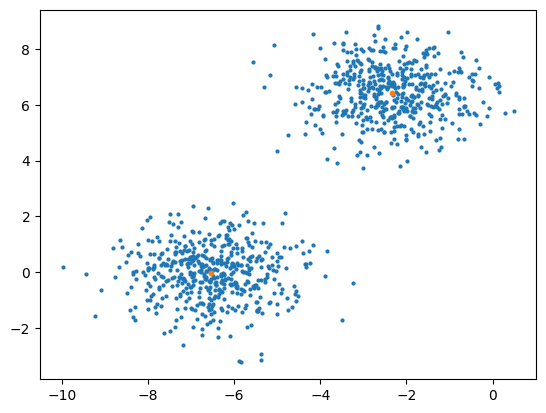

In [6]:
n = 1000
X, Y = make_blobs(n, centers=2, cluster_std=1.)
W, D, U = c_means(c = 2, X=X, m = 2)
plt.scatter(X[...,0], X[..., 1], s=4)
plt.scatter(W[:, 0], W[:, 1], s=10)
plt.show()

/var/folders/x0/tqjt41r52bd_0pkfnp1g_jcc0000gp/T/ipykernel_11058/918614822.py:39: UserWarning: linewidths is ignored by contourf
  ax.contourf(x,y,u[:,cl].reshape(x.shape),levels = 7, alpha=.5,cmap=color[cl],linewidths=3,extend='max')


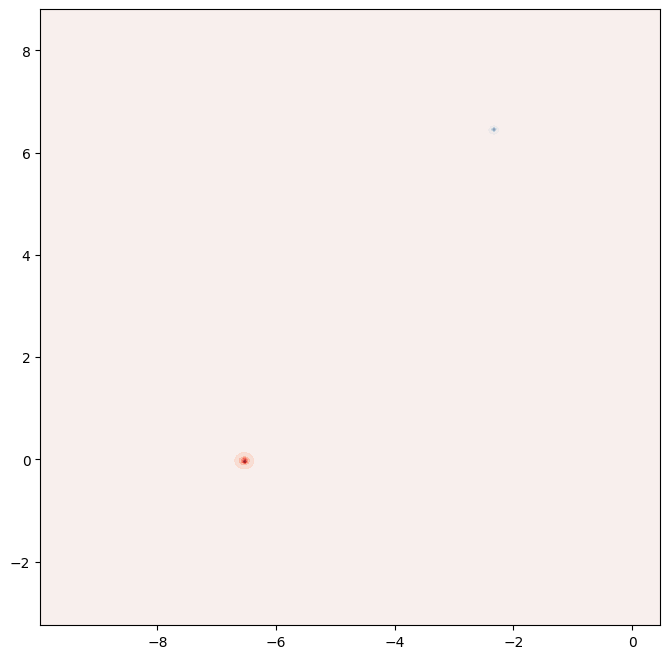

In [7]:
plot_contour(X, c_means, 2, 2)

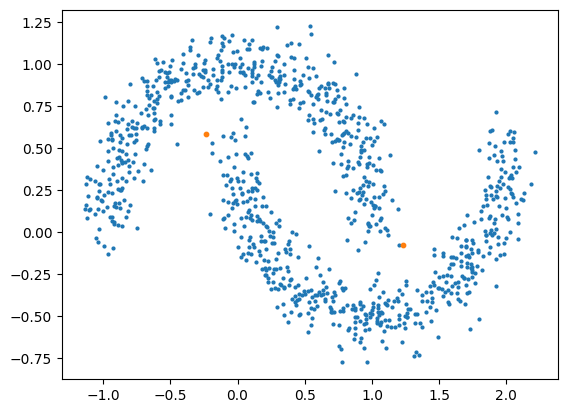

In [8]:
n = 1000
X, Y = make_moons(n, noise=0.1)
W, D, U = c_means(c = 2, X=X, m = 2)
plt.scatter(X[...,0], X[..., 1], s=4)
plt.scatter(W[:, 0], W[:, 1], s =10)
plt.show()

/var/folders/x0/tqjt41r52bd_0pkfnp1g_jcc0000gp/T/ipykernel_11058/918614822.py:39: UserWarning: linewidths is ignored by contourf
  ax.contourf(x,y,u[:,cl].reshape(x.shape),levels = 7, alpha=.5,cmap=color[cl],linewidths=3,extend='max')


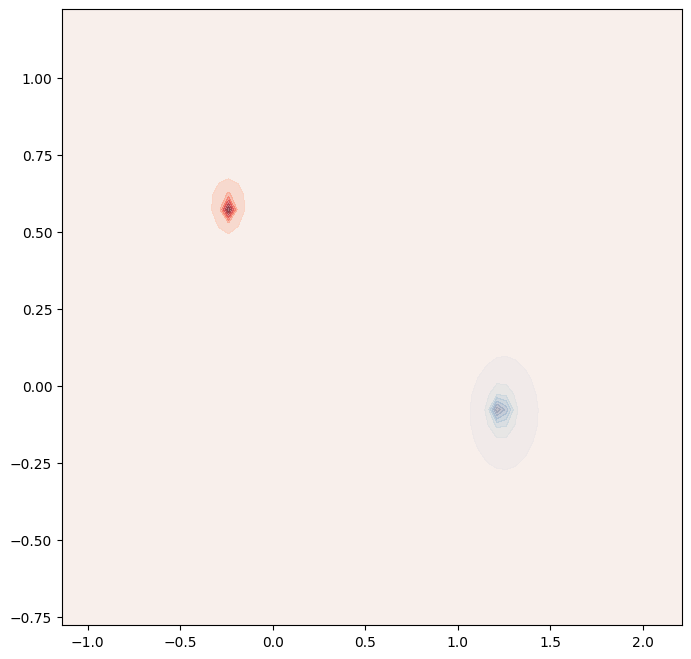

In [9]:
plot_contour(X, c_means, 2, 2)

## Possibilistes

In [10]:
def update_U_poss(D, U, m, eta_r):
    for i in range(len(U)):
        for r in range(len(U[0])):
            somme = 0.
            for s in range(len(U[0])):
                somme += (D[i, r]/eta_r)**(2/(m-1))
            U[i, r] = 1/somme
    return U

In [11]:
def c_means_possibilistes(c, X, eta_r=0.01, m=2):
    n = len(X)
    d = len(X[0])
    # distance
    D = np.zeros(shape=(n, c))
    # degre d'appartenance
    U = np.zeros(shape=(n, c))

    W = init_W(X, c, d)
    converged = False
    while not converged:
        D = update_D(D, X, W)
        U = update_U_poss(D, U, m, eta_r)
        W_new = update_W(W, U, X, m)
        
        if is_converged(W_old=W, W_new=W_new, thresh=1e-1):
            converged = True
        W = W_new
    return W, D, U

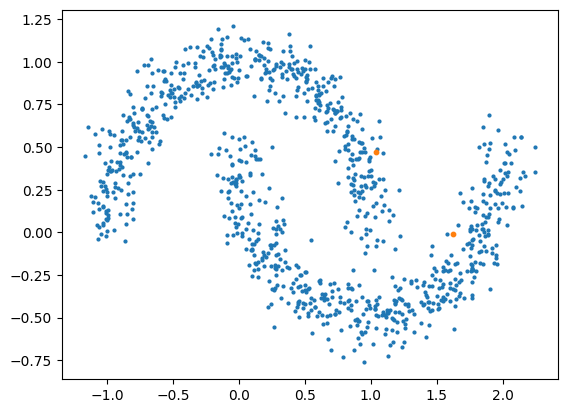

In [12]:
n = 1000
c = 2
X, Y = make_moons(n, noise=0.1)
W, D, U = c_means_possibilistes(c = 2, X=X, eta_r=0.01, m = 2)
plt.scatter(X[...,0], X[..., 1], s=4)
plt.scatter(W[:, 0], W[:, 1], s=10)
plt.show()

/var/folders/x0/tqjt41r52bd_0pkfnp1g_jcc0000gp/T/ipykernel_11058/918614822.py:39: UserWarning: linewidths is ignored by contourf
  ax.contourf(x,y,u[:,cl].reshape(x.shape),levels = 7, alpha=.5,cmap=color[cl],linewidths=3,extend='max')


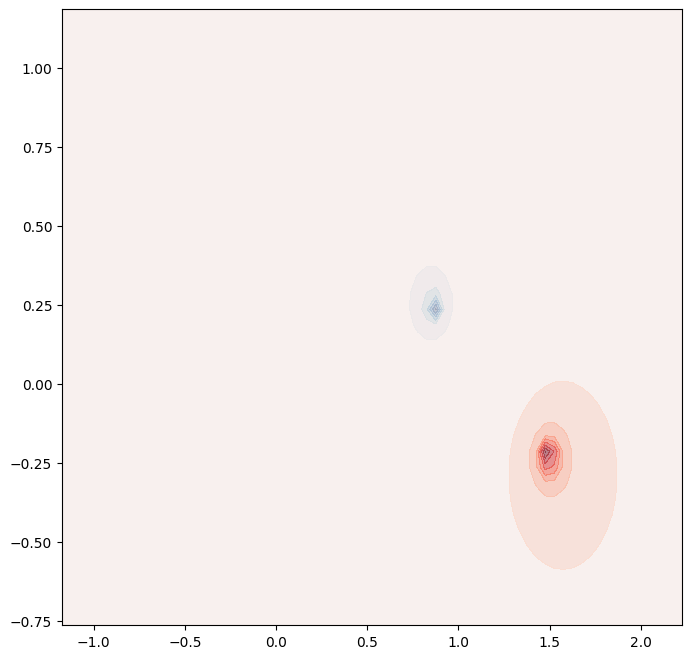

In [13]:
plot_contour(X, c_means_possibilistes, 2, 2)

## Comparaisons avec d'autres algorithmes de clustering

### Gaussian Mixture Models

In [14]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, covariance_type='full', tol=0.001, max_iter=100, n_init=1, init_params='kmeans', random_state=None, verbose=0)
gmm.fit(X)

GaussianMixture(n_components=2)

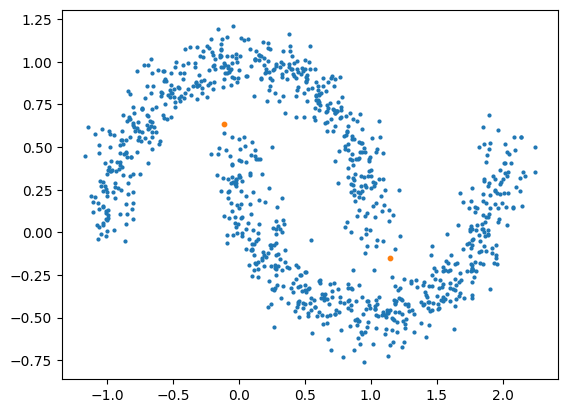

In [15]:
plt.scatter(X[...,0], X[..., 1], s=4)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=10)
plt.show()

In [16]:
import itertools
import matplotlib as mpl
# a partir de https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html
color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = np.linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9.0, 5.0)
    plt.ylim(-3.0, 6.0)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

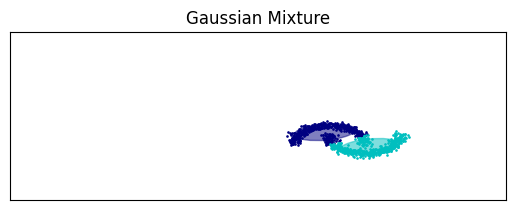

In [17]:
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, "Gaussian Mixture")

### Clustering Hierarchique

In [18]:
from sklearn.cluster import AgglomerativeClustering
agg_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0.5)
model_agg_clust = agg_clust.fit(X)

In [19]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

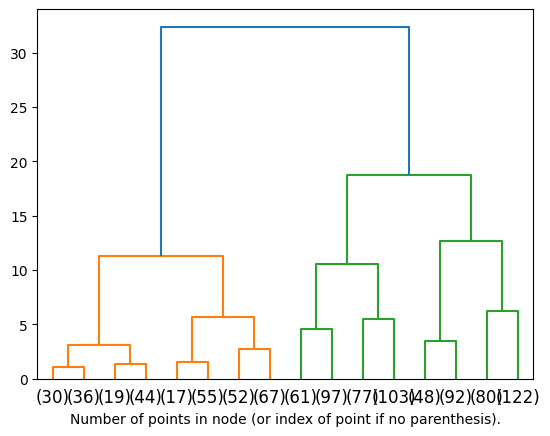

In [20]:
plot_dendrogram(model_agg_clust, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Clustering Spectral

In [21]:
from sklearn.cluster import SpectralClustering
spec_clust = SpectralClustering(n_clusters=2, random_state=None, n_init=10, gamma=1.0, affinity='rbf', degree=3, coef0=1)
labels = spec_clust.fit_predict(X)

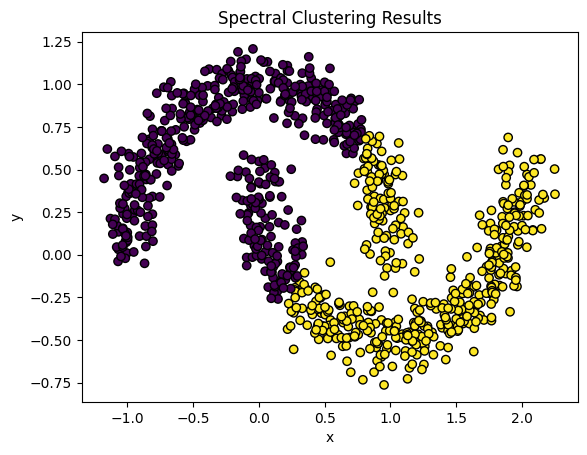

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolor='k')
plt.title('Spectral Clustering Results')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### DBScan

In [27]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.13, min_samples=5)
labels = dbscan.fit_predict(X)

Note: nous avons essayé plusieurs configurations (epsilon) DBSCAN pour obtenir une classification satisfaisante.

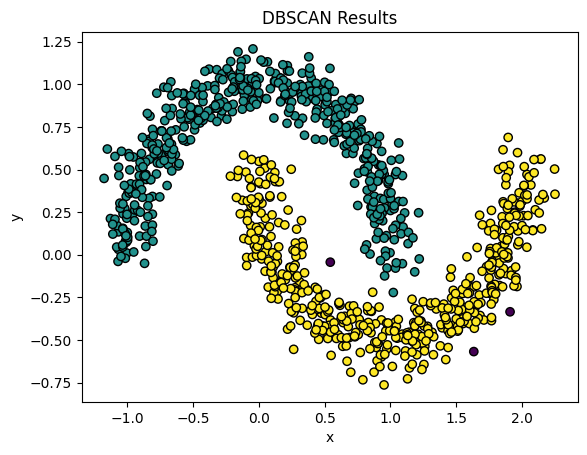

In [28]:
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolor='k')
plt.title('DBSCAN Results')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Conclusions

Les algorithmes de clustering sont utiles pour une méthode de classification qui a la limitation de générer une fonction d'appartenance binaire, ce qui n'est pas le cas dans la plupart des tâches de classification dans des applications réelles.

Les clusters non gaussiens permettent de voir l'efficacité et la robustesse des algorithmes. Dans le cas des Half Moons, l'algorithme dépend fortement d'une fonction de distances $d_{ir} = ||x_i - w_r||^{2}$ qui se voit affectée par la distribution des données, Ce qui cause que les distances causent que les longues distances aux poids causent une forte pénalisation à l'appartennance à un certain centre du cluster.